In [1]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry, SamPredictor
import cv2
import matplotlib.pyplot as plt # Plotting
import numpy as np # Numeric data
import pandas as pd # Tabular data
from rasterio.features import shapes # Vectorising rasters to polygons
from shapely import Point, LineString # Geometry
from shapely.geometry import box, shape
import geopandas as gpd # Plotting polygons
from tqdm.auto import tqdm # Progress bars
tqdm.pandas()

In [2]:
# Load SegmentAnything
checkpoint = 'sam_vit_h_4b8939.pth'
sam = sam_model_registry['vit_h'](checkpoint=checkpoint)
device = 'cuda:0'
sam.to(device)

img = cv2.cvtColor(cv2.imread('test.png'), cv2.COLOR_BGR2RGB)

In [66]:
masks = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=50, # The number of points to be sampled along one side of the image
    pred_iou_thresh=0.88, # A filtering threshold in [0,1], using the model's predicted mask quality.
    stability_score_thresh=0.95, # The amount to shift the cutoff when calculated the stability score.
    box_nms_thresh=0.7, # The box IoU cutoff used by non-maximal suppression to filter duplicate masks.
    crop_nms_thresh=0.7, # The box IoU cutoff used by non-maximal suppression to filter duplicate masks between different crops.
    crop_n_layers=0, #  If >0, mask prediction will be run again on crops of the image. Sets the number of layers to run, where each layer has 2**i_layer number of image crops.
    crop_n_points_downscale_factor=1, # The number of points-per-side sampled in layer n is scaled down by crop_n_points_downscale_factor**n.
    min_mask_region_area=100, # If >0, postprocessing will be applied to remove disconnected regions and holes in masks with area smaller than min_mask_region_area
).generate(img)
len(masks)

211

In [67]:
masks = sorted(masks, key=(lambda x: x['area']), reverse=True)
full_mask = np.zeros_like(masks[0]["segmentation"]).astype(int)
for i in range(len(masks)):
   x, y = np.where(masks[i]['segmentation'])
   full_mask[x,y] = i + 1

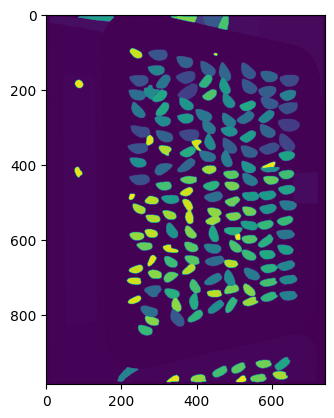

In [68]:
plt.imshow(full_mask)

In [131]:
# Vectorise raster
shape_gen = ((shape(s), v) for s, v in shapes(full_mask.astype(np.uint8), mask=full_mask>0))
# Convert shapes to GeoDataFrame, taking CRS from the image
df = gpd.GeoDataFrame(dict(zip(["geometry", "id"], zip(*shape_gen))))
df

geometry     id
0    POLYGON ((503.000 7.000, 503.000 8.000, 511.00...    5.0
1    POLYGON ((520.000 7.000, 520.000 8.000, 526.00...    5.0
2    POLYGON ((531.000 7.000, 531.000 8.000, 536.00...    5.0
3    POLYGON ((489.000 7.000, 492.000 7.000, 492.00...    5.0
4    POLYGON ((97.000 12.000, 97.000 13.000, 98.000...    2.0
..                                                 ...    ...
784  POLYGON ((584.000 973.000, 584.000 974.000, 58...    4.0
785  POLYGON ((582.000 974.000, 582.000 975.000, 58...    4.0
786  POLYGON ((522.000 961.000, 527.000 961.000, 52...  206.0
787  POLYGON ((345.000 960.000, 349.000 960.000, 34...  203.0
788  POLYGON ((667.000 850.000, 672.000 850.000, 67...    4.0

[789 rows x 2 columns]

<Axes: >

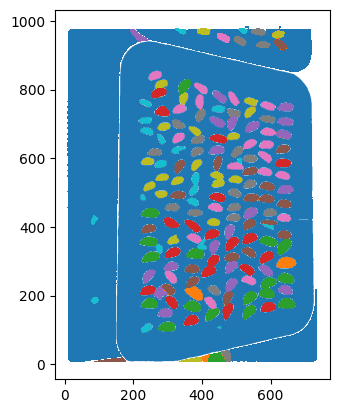

In [132]:
df.plot(column="id", categorical=True)

In [133]:
df["area"] = df.area

<Axes: >

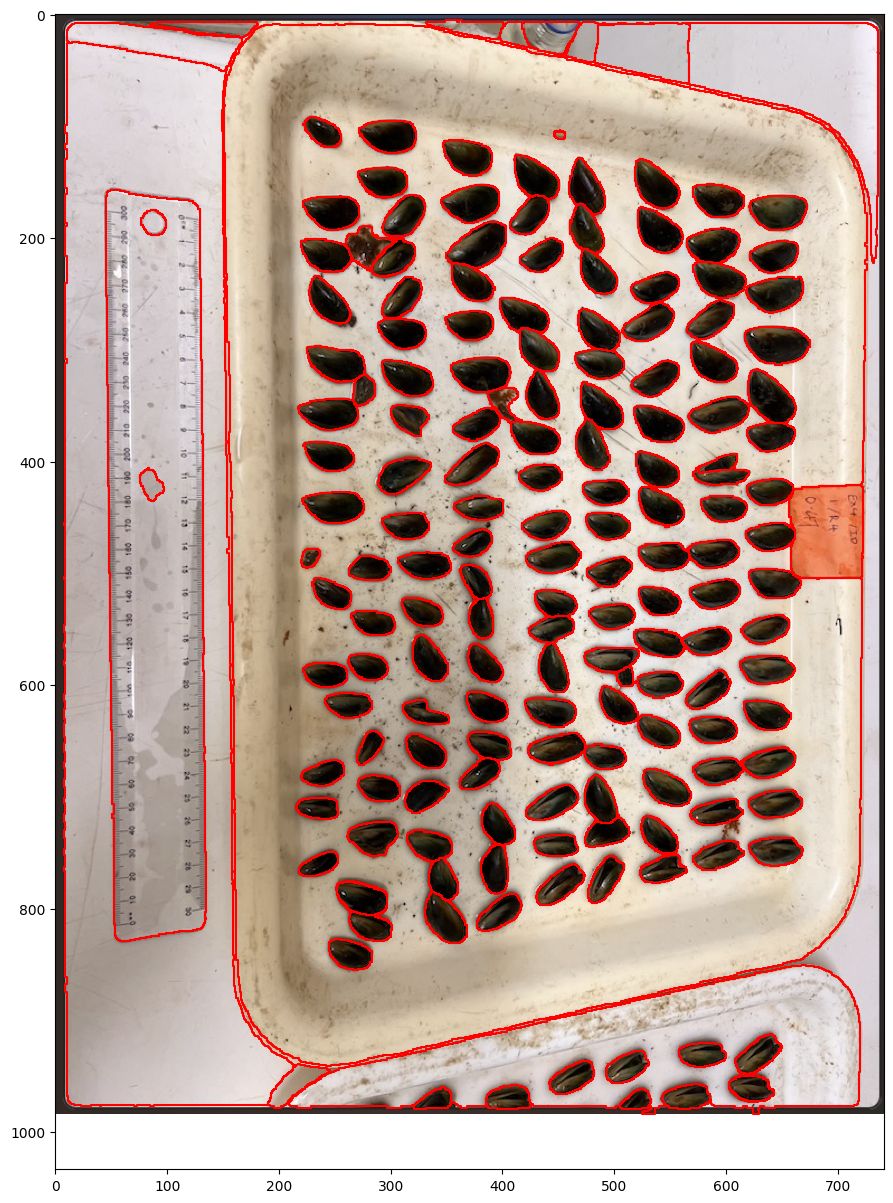

In [134]:
plt.figure(figsize=(15,15))
plt.imshow(img)
df.boundary.plot(color="red", ax=plt.gca())

In [135]:
df = df.sort_values(by="area", ascending=False)
df

geometry    id      area
744  POLYGON ((194.000 8.000, 201.000 8.000, 201.00...   1.0  345368.0
780  POLYGON ((11.000 24.000, 12.000 24.000, 12.000...   2.0   84878.0
726  POLYGON ((49.000 157.000, 58.000 157.000, 58.0...   3.0   54413.0
788  POLYGON ((667.000 850.000, 672.000 850.000, 67...   4.0   34576.0
176  POLYGON ((564.000 7.000, 727.000 7.000, 727.00...   5.0   14485.0
..                                                 ...   ...       ...
111  POLYGON ((324.000 187.000, 324.000 188.000, 32...  18.0       1.0
116  POLYGON ((606.000 193.000, 606.000 194.000, 60...  13.0       1.0
117  POLYGON ((283.000 195.000, 283.000 196.000, 28...  26.0       1.0
118  POLYGON ((461.000 195.000, 461.000 196.000, 46...  22.0       1.0
394  POLYGON ((567.000 476.000, 567.000 477.000, 56...  23.0       1.0

[789 rows x 3 columns]

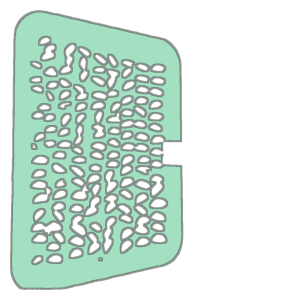

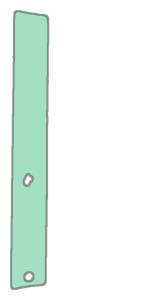

In [136]:
# Tray is largest, then the desk, then the ruler
tray = df.iloc[0]
display(tray.geometry)
ruler = df.iloc[2]
display(ruler.geometry)

In [137]:
ruler

geometry    POLYGON ((49 157, 58 157, 58 158, 62 158, 62 1...
id                                                        3.0
area                                                  54413.0
Name: 726, dtype: object

In [138]:
x1, y1, x2, y2 = ruler.geometry.bounds
ruler_height = y2 - y1
# pixels to cm conversion. ruler is 32cm long
px_per_cm = ruler_height / 32
px_per_cm

21.0

In [139]:
df["centroid"] = df.centroid

In [140]:
df.iloc[0].centroid.coords[0]

(416.7078102198235, 471.1600553612379)

0it [00:00, ?it/s]

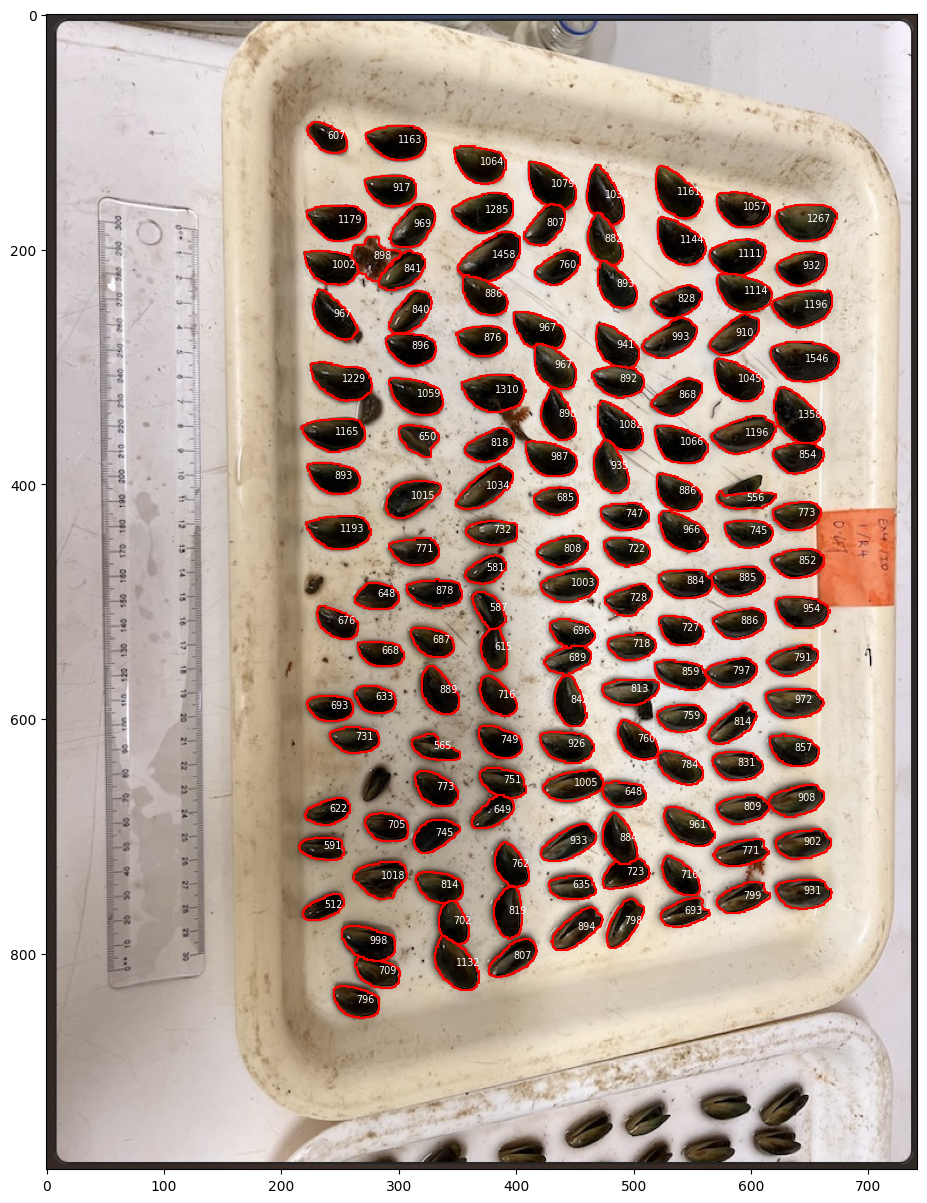

In [151]:
# Filter to just shapes in the tray
df = df[df.within(box(*tray.geometry.bounds).buffer(-5)) & (df.area > 500)]
plt.figure(figsize=(15,15))
plt.imshow(img)
df.boundary.plot(ax=plt.gca(), color="red")
for i, row in tqdm(df.iterrows()):
  plt.annotate(round(row.area), row.centroid.coords[0], color="white", fontsize="x-small")

In [152]:
df

geometry     id    area   
266  POLYGON ((629.000 279.000, 653.000 279.000, 65...   37.0  1546.0  \
179  POLYGON ((386.000 185.000, 396.000 185.000, 39...   39.0  1458.0   
317  POLYGON ((627.000 317.000, 629.000 317.000, 62...   44.0  1358.0   
300  POLYGON ((374.000 307.000, 397.000 307.000, 39...   46.0  1310.0   
106  POLYGON ((375.000 152.000, 388.000 152.000, 38...   47.0  1285.0   
..                                                 ...    ...     ...   
432  POLYGON ((366.000 492.000, 374.000 492.000, 37...  196.0   587.0   
396  POLYGON ((381.000 460.000, 384.000 460.000, 38...  197.0   581.0   
523  POLYGON ((322.000 613.000, 331.000 613.000, 33...  198.0   565.0   
351  POLYGON ((606.000 405.000, 607.000 405.000, 60...  109.0   556.0   
677  POLYGON ((242.000 749.000, 250.000 749.000, 25...  199.0   512.0   

                    centroid                                  diameter_line  
266  POINT (645.929 294.870)  LINESTRING (675.000 297.000, 617.000 285.000)  
179  POINT (379.453 206.754)  LINESTRING (403.000 189.000, 350.000 218.000)  
317  POINT (639.831 343.005)  LINESTRING (659.000 362.000, 624.000 318.000)  
300  POINT (381.900 321.547)  LINESTRING (408.000 321.000, 354.000 313.000)  
106  POINT (373.265 168.365)  LINESTRING (397.000 159.000, 345.000 168.000)  
..                       ...                                            ...  
432  POINT (377.100 507.011)  LINESTRING (388.000 521.000, 364.000 493.000)  
396  POINT (374.693 473.182)  LINESTRING (391.000 466.000, 356.000 479.000)  
523  POINT (329.781 625.263)  LINESTRING (352.000 633.000, 311.000 618.000)  
351  POINT (596.162 413.376)  LINESTRING (621.000 408.000, 571.000 413.000)  
677  POINT (236.367 760.650)  LINESTRING (253.000 753.000, 218.000 768.000)  

[143 rows x 5 columns]

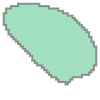

In [192]:
sample = df.sample(1)
poly = sample.geometry.iloc[0]
poly

In [193]:
# Get diameter of polygon by brute force, checking each point pair
def get_diameter(poly):
    max_dist = 0
    coords = [Point(x,y) for x,y in poly.exterior.coords]
    result_coords = []
    for a in coords:
        for b in coords:
            dist = a.distance(b)
            if dist > max_dist:
                max_dist = dist
                result_coords = [a, b]

    line = LineString(result_coords)
    return line

line = get_diameter(poly)
line, line.length

(<LINESTRING (321 206, 284 232)>, 45.221676218380054)

Text(302.5, 219.0, '45.22px')

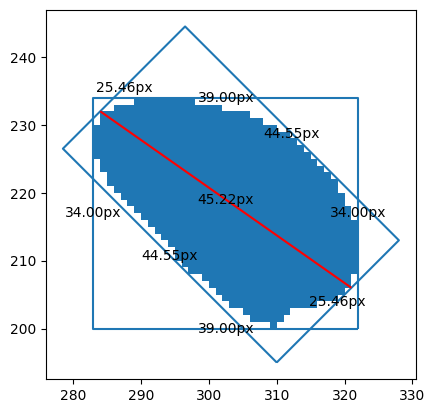

In [194]:
def get_dist(a, b):
    return Point(a).distance(Point(b))

def midpoint(a, b):
    return ((a[0]+b[0])/2, (a[1]+b[1])/2)

def annotate_dist(poly):
    coords = list(poly.exterior.coords)
    for i in range(len(coords)-1):
        a, b = coords[i], coords[i+1]
        dist = get_dist(a, b)
        plt.annotate(f"{dist:.2f}px", xy=midpoint(a, b), ha='center', va='center')

mrr = poly.minimum_rotated_rectangle
bbox = box(*poly.bounds)
line = get_diameter(poly)

ax = gpd.GeoSeries([poly, mrr.exterior, bbox.exterior]).plot()
gpd.GeoSeries(line).plot(color="red", ax=ax)
annotate_dist(bbox)
annotate_dist(mrr)
plt.annotate(f"{line.length:.2f}px", xy=midpoint(*list(line.coords)), ha='center', va='center')

In [195]:
df["diameter_line"] = df.geometry.progress_apply(get_diameter)
df["diameter_line"]

  0%|          | 0/143 [00:00<?, ?it/s]

266    LINESTRING (675.000 297.000, 617.000 285.000)
179    LINESTRING (403.000 189.000, 350.000 218.000)
317    LINESTRING (659.000 362.000, 624.000 318.000)
300    LINESTRING (408.000 321.000, 354.000 313.000)
106    LINESTRING (397.000 159.000, 345.000 168.000)
                           ...                      
432    LINESTRING (388.000 521.000, 364.000 493.000)
396    LINESTRING (391.000 466.000, 356.000 479.000)
523    LINESTRING (352.000 633.000, 311.000 618.000)
351    LINESTRING (621.000 408.000, 571.000 413.000)
677    LINESTRING (253.000 753.000, 218.000 768.000)
Name: diameter_line, Length: 143, dtype: geometry

In [196]:
ruler.diameter_line = get_diameter(ruler.geometry)

  0%|          | 0/143 [00:00<?, ?it/s]

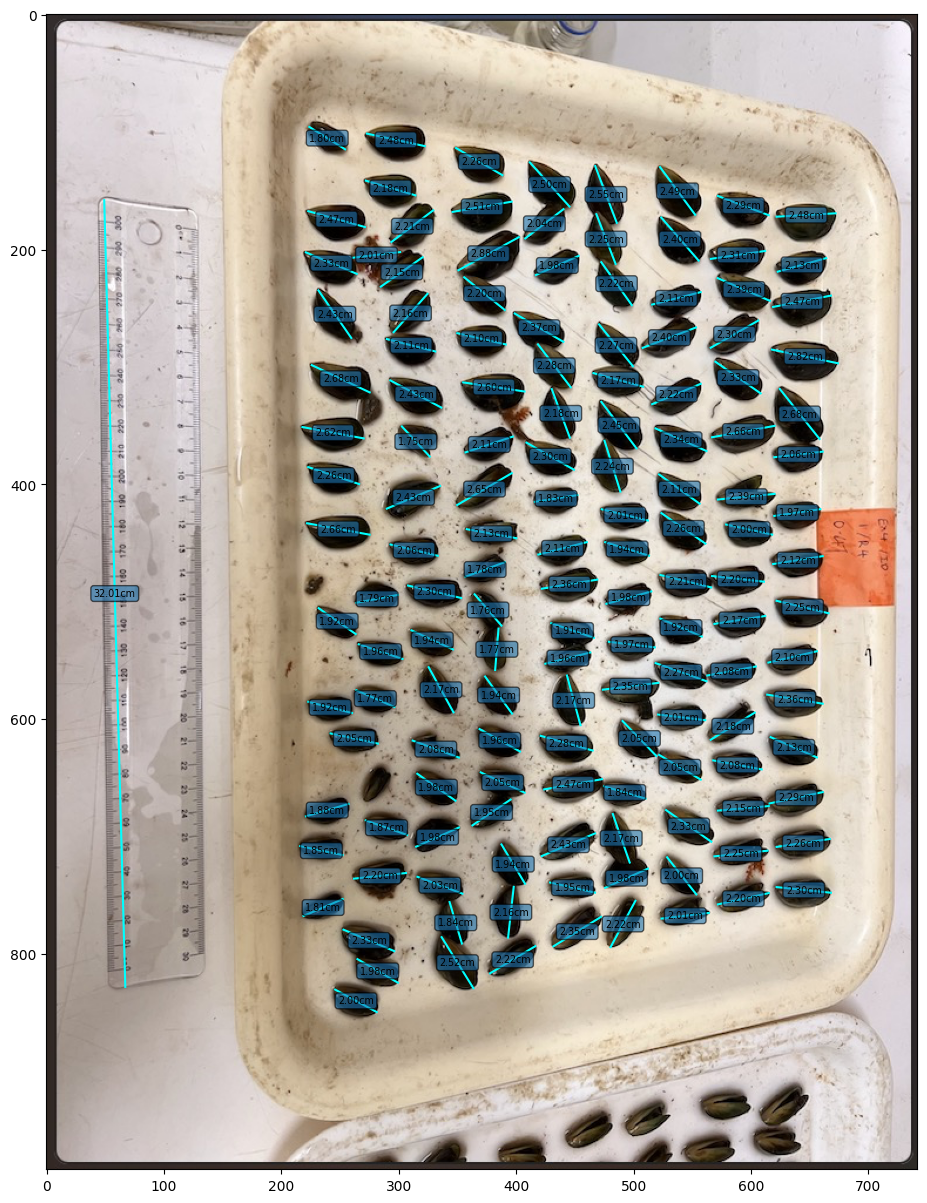

In [197]:
def annotate_length(line):
    gpd.GeoSeries(line).plot(color="cyan", ax=plt.gca())
    x, y = midpoint(*list(line.coords))
    plt.text(s=f"{line.length/px_per_cm:.2f}cm", x=x, y=y, ha='center', va='center', bbox=dict(boxstyle="round", alpha=.6), fontsize="x-small")

plt.figure(figsize=(15,15))
plt.imshow(img)
annotate_length(ruler.diameter_line)
for line in tqdm(df.diameter_line):
    annotate_length(line)

In [198]:
df["length_cm"] = df.diameter_line.length / px_per_cm
df.length_cm.describe()

count    143.000000
mean       2.182314
std        0.235152
min        1.752226
25%        1.999716
50%        2.171763
75%        2.325546
max        2.876916
Name: length_cm, dtype: float64